## Environment configuration

In [1]:
import numpy as np
import os
import sys, time
sys.path.append('../')
import matplotlib.pyplot as plt
import PIL.Image as Image
%matplotlib inline
from keras.applications import InceptionV3
from model.loss import change_mask_loss
from model.metric import change_mask_all_accuracy, change_mask_change_accuracy
from keras.applications.xception import preprocess_input
from keras.callbacks import Callback, EarlyStopping
from model.DepthwiseConv2D import DepthwiseConv2D
from model.switchnorm import SwitchNormalization
from keras.utils import multi_gpu_model
from keras.optimizers import *
from keras.models import load_model
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from model.core_model import model_v5_test as my_model_test
from dataload.data_generator_order import *

mask_size  = (63, 63)
heatmap_height = mask_size[0]
heatmap_width  = mask_size[1]


/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
base_project = os.path.abspath('../')
model_name = 'model_v5'
image_size = (512, 512)

data_dir    = os.path.join(base_project, 'dataspace/')

model_path = os.path.join(base_project,  'checkpoints/' + model_name)


In [3]:
def toImg(x):
    return np.uint8(np.asarray((np.squeeze(x) + 1) * 127.5))

def display_images(images, cols=4, cmap=None, norm=None, interpolation=None):
    plt.figure(figsize=(18, 18 * cols))
    i = 1
    titles = ['A_image', 'B_image', 'A_changed', 'B_changed']
#     titles = ['A_image', 'B_image', 'A_points']
    for one_image in images:
        one_image = toImg(one_image)
        plt.subplot(1, cols, i)
        plt.axis('off')
        plt.imshow(one_image.astype(np.uint8), cmap=cmap, norm=norm, interpolation=interpolation)
        plt.title(titles[i-1])
        i += 1
    plt.show()
    
def display_heatmap(maps, cols=4, cmap=None, norm=None, interpolation=None):
    plt.figure(figsize=(18, 18 * cols))
    i = 1
    titles = ['A_points', 'B_points', 'Predition',  'Errors']
    for mp in maps:
        mp = np.squeeze(mp)
        mp = mp - np.min(mp)
        mp = mp / (np.max(mp) + 1e-18)
        mp = np.uint8(mp * 255)
        plt.subplot(1, cols, i)
        plt.axis('off')
        plt.imshow(mp, cmap=cmap, norm=norm, interpolation=interpolation)
        plt.title(titles[i-1])
        i += 1
    plt.show()
def res_sku_points(sku_points, heatmap, HEATMAP_HEIGHT=heatmap_height, HEATMAP_WIDTH=heatmap_width):
    # calculate the resting of skus
    heatmap = np.squeeze(heatmap, axis=-1)
    predict_res = {}
    for sku, point_list in sku_points.items():
        if len(point_list) > 0:
            predict_point_list = []
            for point in point_list:
                h, w = float(point[1]), float(point[0])
                if 0 <= h < 1 and 0 <= w < 1:
                    h, w = int(h * HEATMAP_HEIGHT), int(w * HEATMAP_WIDTH)
                    x = heatmap[h][w]
                    if x < 0.5:
                        # unchange
                        predict_point_list.append(point)
            if len(predict_point_list) > 0:
                predict_res[sku] = len(predict_point_list) # unchanged sku number
    return predict_res

def cal_sku_number(sku_points):
    # calculate the resting of skus
    predict_res = {}
    for sku, point_list in sku_points.items():
        if len(point_list) > 0:
            predict_point_list = []
            for point in point_list:
                predict_point_list.append(point)
            if len(predict_point_list) > 0:
                predict_res[sku] = len(predict_point_list) # unchanged sku number
    return predict_res

def cmp_res_sku(pred_sku_points, true_sku_points):
    flag = True
    if len(pred_sku_points) == len(true_sku_points):
        for sku, num in true_sku_points.items():
            if sku not in pred_sku_points.keys():
                flag = False
                break
            if pred_sku_points[sku] != num:
                flag = False
                break
    else:
        flag = False
    return flag

def sku_sum(dict_data):
    sumup = 0
    for v in dict_data.values():
        sumup += v
    return sumup

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 63, 63, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
pm_conv_1 (Conv2D)              (None, 63, 63, 16)   144         input_2[0][0]                    
__________________________________________________________________________________________________
vision_mod

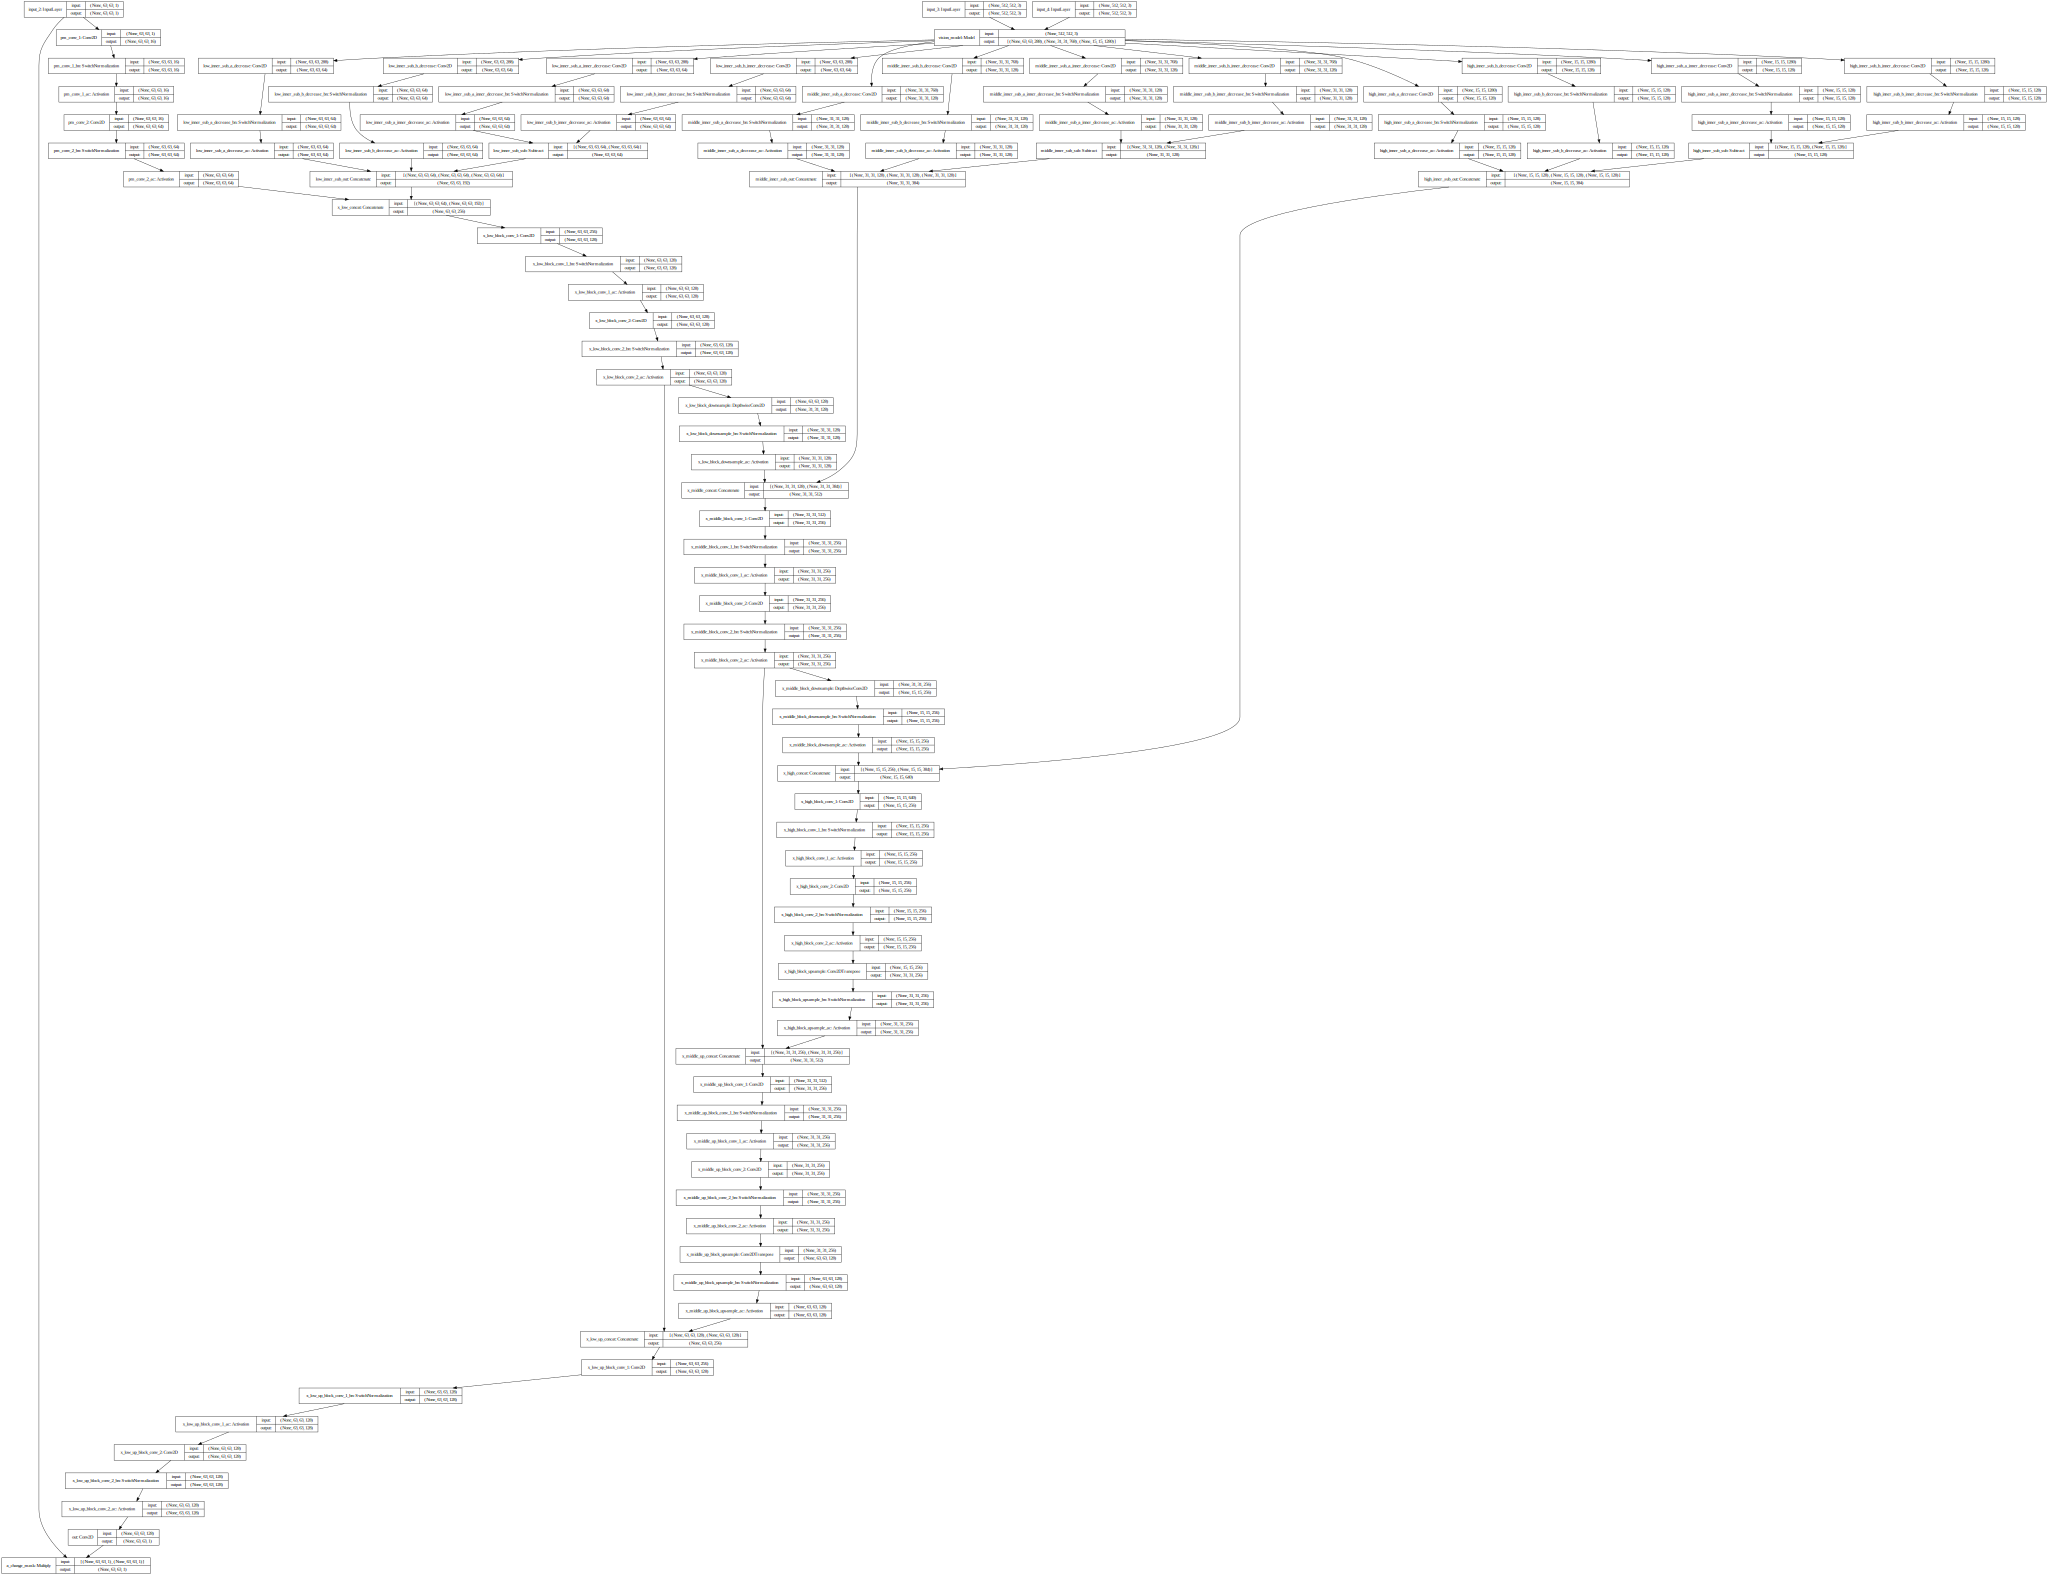

In [4]:
test_model = my_model_test()
test_model.summary()
SVG(model_to_dot(test_model, show_shapes=True).create(prog='dot', format='svg'))

In [5]:
model_h5 = 'model_v5_201901080215_0.0259_0.9385_model.h5'
test_model.load_weights(os.path.join(model_path, model_h5))
multi_model = multi_gpu_model(test_model, gpus=2)

In [6]:

datset = 'task93_12_test'

eval_batch_size = 48
threshold = 0.06

gen = MyImageDataGenerator(preprocessing_function = preprocess_input)
eval_generator = gen.myflow_from_directory(os.path.join(data_dir, datset), 
                                           target_size       = image_size,
                                           x_threshold        = threshold,
                                           y_threshold        = threshold,
                                           simple_take_flag   = True,
                                           skip_movement_flag = False,
                                           heatmap_height     = heatmap_height,
                                           heatmap_width      = heatmap_width,
                                           batch_size         = eval_batch_size,
                                           return_path        = True)

print('{} batches. '.format(len(eval_generator)))
eval_generator.reset()


Found 6025 image pairs.
126 batches. 


In [7]:
# under the constraints of 
import shutil
eval_generator.reset()

total_sum = 0
count_sum = 0
valid_sum = 0
point_sum = 0
invalid_sum = 0

count_point_sum = 0
valid_point_sum = 0
point_count_sum = 0
valid_count_sum = 0
valid_depoint_sum = 0

invalid_result = []
depoint_result = []

pred_txt = os.path.join(base_project, 'analysis', model_h5[:-3] + '_' + datset + '_' + str(threshold) + '.txt')

with open(pred_txt, 'w') as f:
    
    for i in range(len(eval_generator)):
        x, y, imgs_list = eval_generator.next()
        y_ress, y_masks = multi_model.predict_on_batch(x)
        for j in range(len(y[0])):
            total_sum += 1
            x_img_a = x[0][j]
            x_img_b = x[1][j]
            x_mask_a = x[2][j]
            x_mask_b = y[0][j]  # the mask of b
            
            y_changed_a = y[1][j]  # heatmap of changed a
            y_changed_b = y[2][j]  # heatmap of changed b

            a_sku_points = imgs_list[j][2]
            b_sku_points = imgs_list[j][3]
            
            y_pred_mask = y_masks[j].round()
            y_pred_res = y_ress[j]
            

            y_diff = abs(y_changed_a - y_pred_mask)

            calc_b_num = int(imgs_list[j][1].split('__')[-1].split('.')[0])

            pred_res_sku = res_sku_points(a_sku_points, y_pred_mask)
            true_res_sku = cal_sku_number(b_sku_points)
            pred_b_sum = sku_sum(pred_res_sku)
            true_b_sum = sku_sum(true_res_sku)

            imgs     = [x_img_a,  x_img_b,  y_changed_a, y_changed_b]
            heatmaps = [x_mask_a, x_mask_b, y_pred_mask, y_diff]

            if calc_b_num == true_b_sum:
                count_sum += 1
                if cmp_res_sku(pred_res_sku, true_res_sku):
                    count_point_sum += 1

            if cmp_res_sku(pred_res_sku, true_res_sku):
                point_sum += 1
                if pred_b_sum == calc_b_num:
                    point_count_sum += 1

            if pred_b_sum == calc_b_num:  # the sum of points and the sum of statistic 
                valid_sum += 1
                if calc_b_num == true_b_sum:
                    valid_count_sum  += 1
                if cmp_res_sku(pred_res_sku, true_res_sku):
                    valid_point_sum += 1
                else:
                    if valid_depoint_sum < 50:
                        depoint_result.append([imgs, heatmaps, imgs_list[j], pred_b_sum, calc_b_num, true_b_sum])
                    valid_depoint_sum += 1
                    f.write('a_im:{}\n'.format(imgs_list[j][0].split('dataspace')[1]))
                    f.write('b_im:{}\n'.format(imgs_list[j][1].split('dataspace')[1]))
                    f.write('{:04d} The diff: {}\n'.format(valid_depoint_sum - 1, np.sum(y_diff)))
            else:
                invalid_sum += 1

        if (i + 1) % 10 == 0:
            print('[{}/{}]'.format(i+1, len(eval_generator)))

valid_ratio     = valid_sum / total_sum  
count_acc       = count_sum / total_sum
point_acc       = point_sum / total_sum

valid_point_acc = valid_point_sum / valid_sum
point_count_acc = point_count_sum / point_sum
count_point_acc = count_point_sum / count_sum

print('Total num:           {}'.format(total_sum))
print('Valid num:           {}**'.format(valid_sum))
print('Valid ratio:         {:.4f}'.format(valid_ratio))

print('-----------------------------------')
print('point num:           {}'.format(point_sum))
print('point accuracy:      {:.4f}'.format(point_acc))

print('-----------------------------------')
print('count num:           {}'.format(count_sum))
print('count accuracy:      {:.4f}'.format(count_acc))

print('-----------------------------------')
print('valid then point:    {:.4f}**'.format(valid_point_acc))
print('count then point:    {:.4f}'.format(count_point_acc))
print('point then count:    {:.4f}'.format(point_count_acc))

print('-----------------------------------')
print('Vilid but incorrect: {}**'.format(valid_depoint_sum))
print('Invilid num:         {}'.format(invalid_sum))

[10/126]
[20/126]
[30/126]
[40/126]
[50/126]
[60/126]
[70/126]
[80/126]
[90/126]
[100/126]
[110/126]
[120/126]
Total num:           6025
Valid num:           5305**
Valid ratio:         0.8805
-----------------------------------
point num:           5457
point accuracy:      0.9057
-----------------------------------
count num:           5705
count accuracy:      0.9469
-----------------------------------
valid then point:    0.9898**
count then point:    0.9204
point then count:    0.9623
-----------------------------------
Vilid but incorrect: 54**
Invilid num:         720


In [8]:
result_tst = depoint_result

/home/ubuntu/Desktop/point-detection-solution/dataspace/task93_12_test/task93_12/1/20181205@102100_1812051025290299444_2_C0412/1543976460_S4_C0412_1812051025290299444_2__31.jpg
/home/ubuntu/Desktop/point-detection-solution/dataspace/task93_12_test/task93_12/1/20181205@102100_1812051025290299444_2_C0412/1544004878_S4_C0412_1812051815180345728_2__24.jpg
point_pred: 24, count_pred: 24, gt_true: 25


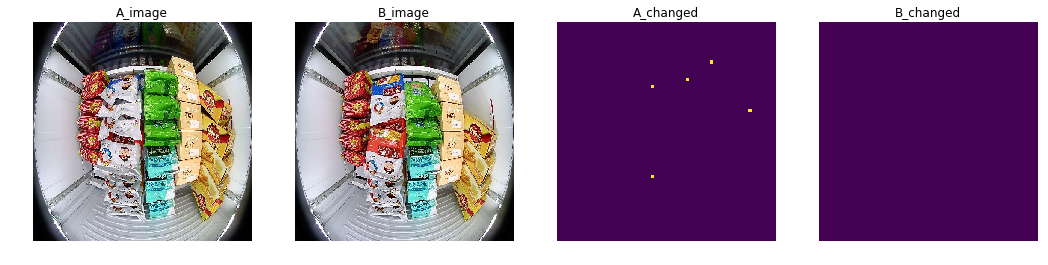

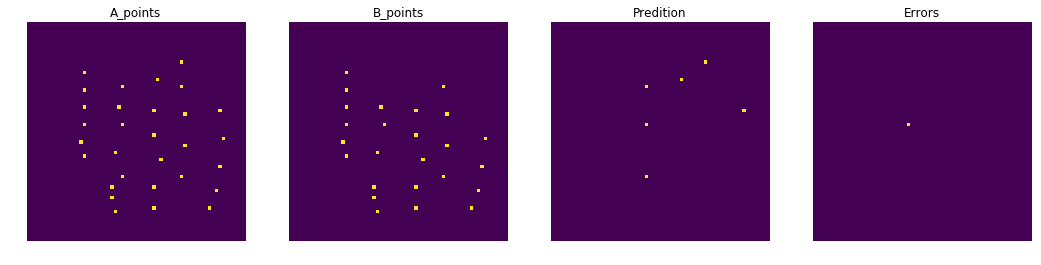

In [9]:
idx = 9

images   = result_tst[idx][0]
heatmaps = result_tst[idx][1]
image_name = result_tst[idx][2]
print(image_name[0])
print(image_name[1])
print('point_pred: {}, count_pred: {}, gt_true: {}'.format(result_tst[idx][3], result_tst[idx][4], result_tst[idx][5]))

display_images(images, cols=len(images))
display_heatmap(heatmaps, cols=len(heatmaps))

In [29]:
# under the constraints of 

eval_generator.reset()
counter = 0
counter1 = 0
counter2 = 0
counter3 = 0
results1 = []
results2 = []
results3 = []
pred_txt = os.path.join(base_project, 'analysis', model_h5[:-3] + '_' + datset + '_' + str(threshold) + '.txt')

with open(pred_txt, 'w') as f:
    for i in range(len(eval_generator)):
        x, y, imgs_list = eval_generator.next()
        y_ress, y_masks = multi_model.predict_on_batch(x)
        for j in range(len(y[0])):
            counter += 1
            y_true = y[j][1]
            a_sku_points = imgs_list[j][2]
            b_sku_points = imgs_list[j][3]
            y_pred_mask = y_masks[j]
            y_pred_res = y_ress[j]

            y_diff = abs(y_true - y_pred_mask.round())
            imgs = [x[0][j], x[1][j], x[2][j], x[2][j]-y_true]
            heatmaps = [y_pred_res, y_pred_mask.round(), y_true, y_diff]
            
            pred_res = res_sku_points(a_sku_points, y_pred_mask.round())
            
            true_res = cal_sku_number(b_sku_points)
            
            if sku_sum(pred_res) == sku_sum(true_res):
                if not cmp_res_sku(pred_res, true_res): # 总数相等，但sku错误
                    counter1 += 1 
                    if counter1 <= 20:
                        results1.append([imgs, heatmaps, imgs_list[j]])

            if cmp_res_sku(pred_res, true_res):
                counter2 += 1
                if counter2 < 20:
                    results2.append([imgs, heatmaps, imgs_list[j]])
            else:
                
                if counter3 <= 40:
                    results3.append([imgs, heatmaps, imgs_list[j]])
                counter3 += 1
                f.write('a_im:{}\n'.format(imgs_list[j][0].split('dataspace')[1]))
                f.write('b_im:{}\n'.format(imgs_list[j][1].split('dataspace')[1]))
                f.write('{:04d} The diff: {}\n'.format(counter3-1, np.sum(y_diff)))
                
        if (i+1)%10 == 0:
            print('[{}/{}]'.format(i+1, len(eval_generator)))

print('Accuracy:{:.4f}'.format(counter1 / counter))
print('Accuracy:{:.4f}'.format(counter2 / counter))
print('Accuracy:{:.4f}'.format(counter3 / counter))
print(counter1)
print(counter2)
print(counter3)

[10/113]
[20/113]
[30/113]
[40/113]
[50/113]
[60/113]
[70/113]
[80/113]
[90/113]
[100/113]
[110/113]
Accuracy:0.0006
Accuracy:0.9586
Accuracy:0.0414
3
5168
223


In [20]:
# under the constraints of 
import shutil
eval_generator.reset()
counter = 0
counter1 = 0
counter2 = 0
counter3 = 0
results1 = []
results2 = []
results3 = []

new_dir = 'pickup3'

for i in range(len(eval_generator)):
    x, y, imgs_list = eval_generator.next()
    y_ress, y_masks = multi_model.predict_on_batch(x)
    for j in range(len(y[0])):
        counter += 1
        y_true = y[j][1]
        a_sku_points = imgs_list[j][2]
        b_sku_points = imgs_list[j][3]
        y_pred_mask = y_masks[j]
        y_pred_res = y_ress[j]

        pred_res = res_sku_points(a_sku_points, y_pred_mask.round())
        true_res = cal_sku_number(b_sku_points)
        
        if cmp_res_sku(pred_res, true_res):
            counter2 += 1
        else:
            counter3 += 1
            a_im = imgs_list[j][0]
            b_im = imgs_list[j][1]
            a_elements = a_im.split('/')
            b_elements = b_im.split('/')
            e_path = ''
            for e in b_elements[:-1]:
                e_path += e + '/'

            new_path = os.path.join(base_project, new_dir, *b_elements[9:-1])
            if not os.path.exists(new_path):
                os.makedirs(new_path)

            new_img_a = os.path.join(new_path, a_elements[-1])
            new_img_b = os.path.join(new_path, b_elements[-1])

            if not os.path.exists(new_img_a):
                shutil.copy(a_im, new_img_a)
                shutil.copy(a_im.replace('.jpg', '.json'), new_img_a.replace('.jpg', '.json'))
                shutil.copy(a_im.replace('.jpg', '_mp.json'), new_img_a.replace('.jpg', '_mp.json'))
            if not os.path.exists(new_img_b):
                shutil.copy(b_im, new_img_b)
                shutil.copy(b_im.replace('.jpg', '.json'), new_img_b.replace('.jpg', '.json'))
                shutil.copy(b_im.replace('.jpg', '_mp.json'), new_img_b.replace('.jpg', '_mp.json'))

    if (i+1)%10 == 0:
        print('[{}/{}]'.format(i+1, len(eval_generator)))

print('Accuracy:{:.4f}'.format(counter2 / counter))
print(counter3)

[10/315]
[20/315]
[30/315]
[40/315]
[50/315]
[60/315]
[70/315]
[80/315]
[90/315]
[100/315]
[110/315]
[120/315]
[130/315]
[140/315]
[150/315]
[160/315]
[170/315]
[180/315]
[190/315]
[200/315]
[210/315]
[220/315]
[230/315]
[240/315]
[250/315]
[260/315]
[270/315]
[280/315]
[290/315]
[300/315]
[310/315]
Accuracy:0.0000
Accuracy:0.8186
0
12373


In [17]:
import os, sys, glob
import numpy as np
sys.path.insert(0, '../')
base_path = os.path.abspath('../')
from dataload.match_produce import *

def read_file(file_name):
    f = open(file_name)
    r = f.read()
    f.close()
    return r

directory = '/home/ubuntu/Dingding/Projects/point-detection/solution_1/dataspace/task92_test'
def _recursive_list(subpath):
    return os.walk(subpath, followlinks=True)
image_pair_list = list()

skip_movement_flag = True
counter = 0
counter1 = 0
counter2 = 0
threshold = 0.06

for x_dirpath, _, third_filenames in _recursive_list(directory):
    if len(third_filenames) != 0:
        valid_filenames = []
        max_num = 0
        first_found = False
        sorted_filenames = sorted(glob.glob(os.path.join(x_dirpath, '*.jpg')))
        if len(sorted_filenames) > 1:
            for x_filename in sorted_filenames:
                num = read_json(x_filename[:-4] + '.json')
                
                now_num = sum(num.values())
                if not first_found and max_num  < now_num:
                    max_num = now_num
                    a_filename = x_filename
                    continue
                else:
                    first_found = True
                    data_path = x_filename[:-4] + '_mp.json'
                    if read_json(data_path) is None:
                        print(data_path)
                    else:
                        if skip_movement_flag:
                            counter += 1
                            a_mp = read_json(a_filename[:-4]+'_mp.json')
                            a_mp = dict([(k, str2float(v)) for k, v in a_mp.items() if len(v) > 0])
                            b_mp = read_json(x_filename[:-4] + '_mp.json')
                            b_mp = dict([(k, str2float(v)) for k, v in b_mp.items() if len(v) > 0])
                            _, b_change_s, _, _, _, _ = match_s(a_mp, b_mp, x_threshod=threshold, y_threshod=threshold)
                            flag  = True
                            for _, val in b_change_s.items():
                                if len(val) > 0:
                                    counter1 += 1
                                    flag = False
                                    break
                            if flag:
                                counter2 += 1

print('Pairs beyond threshold: {}'.format(counter1))
print('Pairs under threshold : {}'.format(counter2))
print('Total valid pairs: {}'.format(counter))
print('valid ratio: {:.4f}'.format(counter2 / counter))


0.06149777704267284